In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dt
import os
from os import path
import h5py
import re
from datetime import datetime
import requests
import calendar
import netCDF4 as nc
import json

In [2]:
'''
Initialize variables
'''

#It can be left blank if the txt file is in the same path as the script
UNR_SITE_LIST_FILE = ''
folder_name = 'data'

lat = round(19.479,1)
lon = round(-156.5,1)

#Format yyyy-dd-MM
start_date = '2019-01-01'
end_date = '2021-29-09'

In [3]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,4) 
    return decimal_year

In [4]:
def days_in_month(date):
    year, month, day = map(int, date.split("-"))
    num_days = calendar.monthrange(year, month)[1]
    return num_days

In [5]:
def generate_coordinate_array():
    lon = []
    lat=[]
    lo=-179.95
    la=-89.95

    for i in range(0,3600):
        lon.append(round(lo,2))
        lo+=0.1

    for i in range(0,1800):
        lat.append(round(la,2))
        la+=0.1
        
    return(lon,lat)

In [6]:
def extract_volcanoes_info(jsonfile, volcanoName):
    f = open(jsonfile)
    data = json.load(f)
    for j in data['features']:
        if j['properties']['VolcanoName'] in volcanoName:
            
            name = (j['properties']['VolcanoName'])
            start = datetime.strptime((j['properties']['StartDate']), '%Y%m%d')
            try:
                end = datetime.strptime((j['properties']['EndDate']), '%Y%m%d')
            except:
                end = 'None'
            print(f'{name} eruption started {start} and ended {end}')

In [7]:
def adapt_coordinates(lon, lat):

    if -179.95 <= lon <= 179.95:

        val = 0.05 if lon > 0 else  -0.05
        lon = lon + val
        
    else:
        raise ValueError(f'Values not in the Interval (-179.5, 179.5)')
        
    if -89.95 <= lat <= 89.95:

        val = 0.05 if lat > 0 else -0.05
        lat = lat + val

    else:
        raise ValueError(f'Values not in the Interval (-89.95, 89.95)')
        
    return lon, lat

In [8]:
def dload_site_list_nc4(folder, path):
    '''
    Creates data folder
    '''
    if not folder:
        folder = 'data'
    
    if not os.path.exists(folder):
        os.mkdir(folder)

    '''
    Looks for list of links i.e. the only txt file in the current folder
    '''
    if not path:
    
        txt_files = [f for f in os.listdir('.') if f.endswith('.txt')]

        if len(txt_files) != 1:
            raise ValueError('should be only one txt file in the current directory')

        path = txt_files[0]
        print(path)

    '''
    Loop torough every line in the list of links .txt file and download every .HDF5 file within the list
    '''

    with open(path, "r") as ifile:
            for URL in ifile:
                if '.nc4' in URL[-6:]:

                    d = re.search('\d{8}', URL)
                    d.group(0)
                    date = datetime.strptime(d.group(0), "%Y%m%d").date()

                    FILENAME = folder + '/'+ str(date) + '.nc4'

                    if not os.path.exists(FILENAME):

                        result = requests.get(URL.strip())

                        try:
                            result.raise_for_status()
                            f = open(FILENAME,'wb')
                            f.write(result.content)
                            f.close()
                            print('contents of URL written to '+FILENAME)
                        except:
                            print('requests.get() returned an error code '+str(result.status_code))

                    else:
                        print(f'File: {FILENAME} already exists')
    return folder

In [9]:
def dload_site_list_hdf5(folder, path):
    '''
    Creates data folder
    '''
    if not folder:
        folder = 'data'
    
    if not os.path.exists(folder):
        os.mkdir(folder)

    '''
    Looks for list of links i.e. the only txt file in the current folder
    '''
    if not path:
    
        txt_files = [f for f in os.listdir('.') if f.endswith('.txt')]

        if len(txt_files) != 1:
            raise ValueError('should be only one txt file in the current directory')

        path = txt_files[0]
        print(path)

    '''
    Loop torough every line in the list of links .txt file and download every .HDF5 file within the list
    '''

    with open(path, "r") as ifile:
            for URL in ifile:
                if '.hdf5' in URL[-6:]:

                    d = re.search('\d{8}', URL)
                    d.group(0)
                    date = datetime.strptime(d.group(0), "%Y%m%d").date()

                    FILENAME = folder + '/'+ str(date) + '.hdf5'

                    if not os.path.exists(FILENAME):

                        result = requests.get(URL.strip())

                        try:
                            result.raise_for_status()
                            f = open(FILENAME,'wb')
                            f.write(result.content)
                            f.close()
                            print('contents of URL written to '+FILENAME)
                        except:
                            print('requests.get() returned an error code '+str(result.status_code))

                    else:
                        print(f'File: {FILENAME} already exists')
    return folder

In [10]:
def plot_precipitaion_hdf5(longitude, latitude, start_date, end_date, folder, path):
        
        finaldf = {}
        df = pd.DataFrame()
        dictionary = {}
        
        lon,lat = generate_coordinate_array()
    
        longitude, latitude = adapt_coordinates(longitude, latitude)

        sdate = datetime.strptime(start_date,'%Y-%d-%m')
        edate = datetime.strptime(end_date,'%Y-%d-%m')
        
        #Create a date range with the input dates, from start_date to end_date
        date_list = pd.date_range(start = sdate,end = edate).date
        
        #If the folder name is left blank, it will be automatically named 'data'
        if not folder:
            folder = 'data'

        '''
        Check if files date is in range with the input dates
        '''   
        
        #Check if folder exists, otherwise execute download function
        if not os.path.exists(folder):
            folder = dload_site_list_hdf5(folder, path)
            
        else:
            
            try:
                
                #Converts file names within the data folder in date
                biggest = datetime.strptime(os.listdir(folder)[-1].replace('.nc4',''),'%Y-%m-%d').date()
                smallest = datetime.strptime(os.listdir(folder)[0].replace('.nc4',''),'%Y-%m-%d').date()
                
                for file in os.listdir(folder):
                
                    if file.endswith('.nc4') and datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date() < smallest:
                        smallest = datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date()

                    if file.endswith('.nc4') and datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date() > biggest:
                        biggest = datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date()

                #Create a range of dates with the name of the files within the data folder
                file_date_list = pd.date_range(start = smallest,end = biggest).date

                #Check if the date range passed as input is within the date range created from the downloaded files
                #if not, launch the download function
                if not all(elem in file_date_list for elem in date_list):
                    
                    folder = dload_site_list_nc4(folder, path)
            except:
                
                folder = dload_site_list_hdf5(folder, path)

        '''
        Loops trough every HDF5 file
        '''
        
        #For each file in the data folder that as HDF5 extension
        for f in os.listdir(folder):

            if f.endswith('.HDF5'):

                file = './' + folder + '/'+ f
                    
                data = h5py.File(file,'r')

                d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
                date = datetime.strptime(d.group(0), "%Y-%d-%m").date()

                if date in date_list:

                    dictionary[str(date)] = {}

                    for key in data.keys():        
                        pre = data[key]['precipitation']
                        lonPrec = dict(zip(lon, zip(*pre)))

                    lonPrec[longitude]

                    i = list(lat).index(latitude)
                    dictionary[str(date)] = lonPrec[longitude][0][i]

                    df1 = pd.DataFrame(dictionary.items(), columns=['Date', 'Precipitation'])
                    finaldf = pd.concat([df,df1], ignore_index=True, sort=False)

                else: continue
                    
        finaldf = finaldf.sort_values(by='Date', ascending=True)
    
        return finaldf  

# PLOT PRECIPITAION FOE NC4 FILES

In [11]:
def plot_precipitaion_nc4(longitude, latitude, start_date, end_date, folder, path):
        
        finaldf = {}
        df = pd.DataFrame()
        dictionary = {}
    
        longitude, latitude = adapt_coordinates(longitude, latitude)

        sdate = datetime.strptime(start_date,'%Y-%d-%m')
        edate = datetime.strptime(end_date,'%Y-%d-%m')
        
        #Create a date range with the input dates, from start_date to end_date
        date_list = pd.date_range(start = sdate,end = edate).date
        
        #If the folder name is left blank, it will be automatically named 'data'
        if not folder:
            folder = 'data'

        '''
        Check if files date is in range with the input dates
        '''   
        
        #Check if folder exists, otherwise execute download function
        if not os.path.exists(folder):
            folder = dload_site_list_nc4(folder, path)
            
        else:
            
            try:
                
                #Converts file names within the data folder in date
                #biggest = [f for f in os.listdir(folder) if f.endswith('.nc4')]
                biggest = datetime.strptime(os.listdir(folder)[-1].replace('.nc4',''),'%Y-%m-%d').date()
                smallest = datetime.strptime(os.listdir(folder)[0].replace('.nc4',''),'%Y-%m-%d').date()
                for file in os.listdir(folder):
                    if file.endswith('.nc4') and datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date() < smallest:
                        smallest = datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date()

                    if file.endswith('.nc4') and datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date() > biggest:
                        biggest = datetime.strptime(file.replace('.nc4',''),'%Y-%m-%d').date()

                #Create a range of dates with the name of the files within the data folder
                file_date_list = pd.date_range(start = smallest,end = biggest).date

                #Check if the date range passed as input is within the date range created from the downloaded files
                #if not, launch the download function
                if not all(elem in file_date_list for elem in date_list):
                    
                    folder = dload_site_list_nc4(folder, path)
            except:
                folder = dload_site_list_nc4(folder, path)
                
        '''
        Create longitude and latitude arrays
        '''               
                
        lon,lat = generate_coordinate_array()
            
        lon_index = lon.index(-156.55)
        lat_index = lat.index(19.05)

        '''
        Loops trough every nc4 file
        '''
        
        #For each file in the data folder that as nc4 extension
        for f in os.listdir(folder):

            if f.endswith('.nc4'):

                #Open the file
                file = './' + folder + '/'+ f
                ds = nc.Dataset(file)
                
                #Extract date from file name
                d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
                date = datetime.strptime(d.group(0), "%Y-%m-%d").date()

                if date in date_list:

                    dictionary[str(date)] = {}

                    data = ds['precipitationCal']
                    data[0,lon_index,lat_index]

                    dictionary[str(date)] = float(data[0,lon_index,lat_index])

                    df1 = pd.DataFrame(dictionary.items(), columns=['Date', 'Precipitation'])
                    finaldf = pd.concat([df,df1], ignore_index=True, sort=False)

                else: continue

        finaldf = finaldf.sort_values(by='Date', ascending=True)
                    
        return finaldf  

In [12]:
extract_volcanoes_info('volcanoes.json', ['Wolf', 'Azul, Cerro', 'Mauna Loa'])

Mauna Loa eruption started 1975-07-05 00:00:00 and ended 1975-07-06 00:00:00
Mauna Loa eruption started 1984-03-25 00:00:00 and ended 1984-04-15 00:00:00
Mauna Loa eruption started 2022-11-27 00:00:00 and ended 2022-12-10 00:00:00
Azul, Cerro eruption started 2008-05-29 00:00:00 and ended 2008-06-17 00:00:00
Azul, Cerro eruption started 1979-01-29 00:00:00 and ended 1979-03-04 00:00:00
Azul, Cerro eruption started 1998-09-15 00:00:00 and ended 1998-10-21 00:00:00
Wolf eruption started 2022-01-06 00:00:00 and ended 2022-04-14 00:00:00
Wolf eruption started 2015-05-25 00:00:00 and ended 2015-07-16 00:00:00
Wolf eruption started 1963-03-04 00:00:00 and ended 1963-03-16 00:00:00
Wolf eruption started 1982-08-28 00:00:00 and ended 1982-09-06 00:00:00
Azul, Cerro eruption started 1967-08-09 00:00:00 and ended None


In [13]:
#If dataset has .nc4 extension
newdf = plot_precipitaion_nc4(lon, lat, start_date, end_date, folder_name, '')

In [14]:
#If dataset has .hdf5 extension
# newdf = plot_precipitaion_hdf5(lon, lat, start_date, end_date, folder_name, '') 

In [15]:
def weekly_precipitation(dictionary):
    weekly_dict = {}
    Precipitation=[]

    if 'Precipitation' in dictionary:
        # Iterate through the dictionary and extract the values for the specified field
        for key, value in dictionary.items():
            if key == 'Precipitation':
                Precipitation.append(value)

    Dates = []
    if 'Date' in dictionary:
        # Iterate through the dictionary and extract the values for the specified field
        for key, value in dictionary.items():
            if key == 'Date':
                Dates.append(value)

    dates_len = len(Dates[0])
    precipitation_len = len(Precipitation[0])
    resto = dates_len % 7

    if len(Dates[0]) == len(Precipitation[0]):

        index = 0
        value = 0

        for i in range (0,dates_len - resto):

            if index < 7:

                value += Precipitation[0][i]
                week = Dates[0][i]
                index += 1

            else:

                weekly_dict[week] = value
                index = 0
                value = 0

        index = 0
        value = 0

        for j in range ((dates_len - resto), dates_len):

            value += Precipitation[0][j]
            week = Dates[0][j]
            index += 1

        weekly_dict[week] = value

    df1 = pd.DataFrame(weekly_dict.items(), columns=['Date', 'Precipitation'])

    plt.gca().xaxis.set_major_locator(dt.DayLocator(interval=6))
    plt.xticks(rotation=90)
    plt.bar(df1['Date'],df1['Precipitation'], color ='maroon',
            width = 0.5)

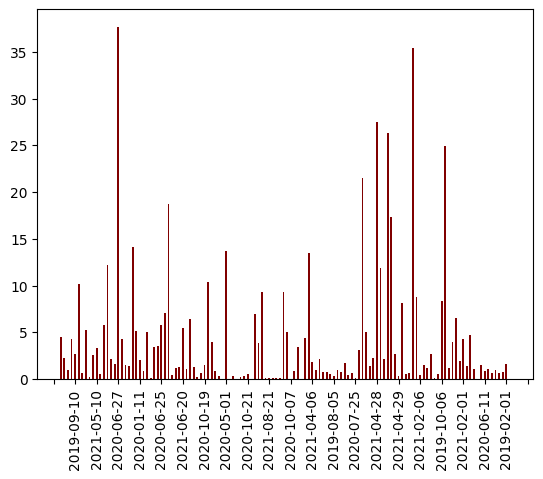

In [16]:
weekly_precipitation(newdf)

In [18]:
monthly_dict = {}
Precipitation=[]

if 'Precipitation' in newdf:
    # Iterate through the dictionary and extract the values for the specified field
    for key, value in newdf.items():
        if key == 'Precipitation':
            Precipitation.append(value)

Dates = []

if 'Date' in newdf:
    # Iterate through the dictionary and extract the values for the specified field
    for key, value in newdf.items():
        if key == 'Date':
            Dates.append(value)

dates_len = len(Dates[0])
precipitation_len = len(Precipitation[0])

if len(Dates[0]) == len(Precipitation[0]):
    
     for i in range (0,dates_len):
            
            if 

    df1 = pd.DataFrame(weekly_dict.items(), columns=['Date', 'Precipitation'])

    plt.gca().xaxis.set_major_locator(dt.DayLocator(interval=6))
    plt.xticks(rotation=90)
    plt.bar(df1['Date'],df1['Precipitation'], color ='maroon',
            width = 0.5)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 27)

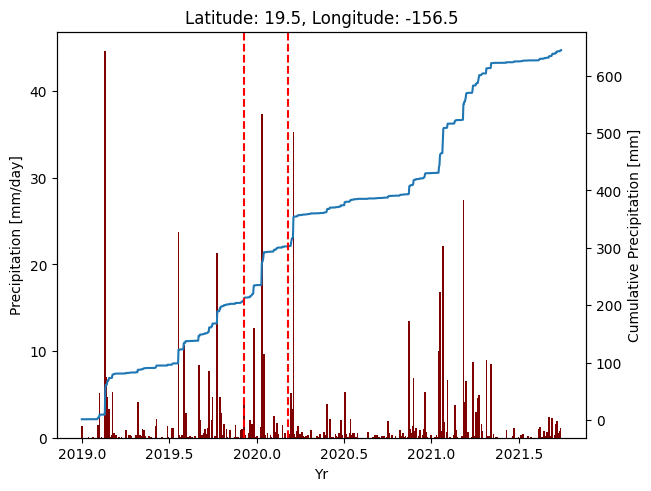

,Date,Precipitation,Decimal_Year,cum
323,2019-01-01,1.320056,2019.0000,1.320056
257,2019-01-02,0.000000,2019.0027,1.320056
292,2019-01-03,0.000000,2019.0055,1.320056
390,2019-01-04,0.000000,2019.0082,1.320056
427,2019-01-05,0.000000,2019.0110,1.320056
...,...,...,...,...
840,2021-09-25,0.000000,2021.7315,642.409336
775,2021-09-26,0.000000,2021.7342,642.409336
818,2021-09-27,0.831682,2021.7370,643.241019
166,2021-09-28,1.075265,2021.7397,644.316284


In [23]:
# newdf["roll7"] = newdf.Precipitation.rolling(7).sum()
# newdf["roll90"] = newdf.Precipitation.rolling(90).sum()
# newdf["roll180"] = newdf.Precipitation.rolling(180).sum()

# newdf["log30"] = np.log(newdf.roll30)
# newdf["log90"] = np.log(newdf.roll90)
# newdf["log180"] = np.log(newdf.roll180)
# newdf['norm']=(newdf.Precipitation-newdf.Precipitation.min())/(newdf.Precipitation.max()-newdf.Precipitation.min())

rainfalldfNoNull = newdf.dropna()

# Convert date strings to decimal years
rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)


rainfalldfNoNull["cum"] = rainfalldfNoNull.Precipitation.cumsum()

fig, ax = plt.subplots(layout='constrained')

# x = rainfalldfNoNull.Decimal_Year
# y = rainfalldfNoNull.Precipitation

plt.bar(rainfalldfNoNull.Decimal_Year, rainfalldfNoNull.Precipitation, color ='maroon',
        width = 0.01)

plt.ylabel("Precipitation [mm/day]")

rainfalldfNoNull.plot('Decimal_Year', 'cum', secondary_y=True, ax=ax)
 
plt.title(f'Latitude: {lat}, Longitude: {lon}')
ax.set_xlabel("Yr")
ax.right_ax.set_ylabel("Cumulative Precipitation [mm]")

ax.get_legend().remove()

plt.xticks(rotation=90)

#Eruptions
plt.axvline(x = date_to_decimal_year('2020-03-06'), color='red', linestyle='--', label='Eruption Date')
plt.axvline(x = date_to_decimal_year('2019-12-06'), color='red', linestyle='--', label='Eruption Date')

# Data plot
plt.show()
rainfalldfNoNull

In [ ]:
'''
Example of global precipitations given by Nasa at: https://gpm.nasa.gov/data/tutorials
'''

data = h5py.File(file,'r')
precip = data['/Grid/precipitation'][:]
precip = np.flip( precip[0,:,:].transpose(), axis=0 )
plt.imshow( precip, vmin=-1, vmax=2, extent=[-180,180,-90,90] )

# -- add a color bar
cbar = plt.colorbar( )
cbar.set_label('millimeters/hour')

# -- display lat/lon grid lines
for lon in np.arange(-90,90+1,90):
  dummy = plt.plot( (lon,lon), (-90,+90), color="black", linewidth=1 )

for lat in np.arange(-60,60+1,30):
  dummy = plt.plot( (-180,+180), (lat,lat), color="black", linewidth=1 )